In [5]:
# Import standard data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

np.random.seed(42)

file_path = r'D:\Documents\UNAI_Notes\HailStorms\data\processed\cleaned_nexrad_data3.csv'



In [6]:
try:
    # Read the data
    df = pd.read_csv(file_path)
    print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    
    # Display the first few rows of the dataset
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
    # If file not found, create synthetic data for demonstration
    print("Creating synthetic data for demonstration...")
    
    # Create synthetic data with realistic distributions
    n_samples = 5000
    
     # Generate synthetic data (reasonable values based on NEXRAD parameters)
    synthetic_data = {
        'Azimuth': np.random.uniform(0, 359.9, n_samples),
        'Range': np.random.uniform(0, 100, n_samples),  # km
        'Differential_Reflectivity': np.random.normal(1.5, 1.2, n_samples),  # dB
        'Specific_Differential_Phase': np.random.gamma(2, 1.5, n_samples),  # degrees/km
        'Spectrum_Width': np.random.lognormal(0.5, 0.6, n_samples),  # m/s
        'Velocity': np.random.normal(0, 15, n_samples)  # m/s
    }
    
    # Create some correlations between variables
    # Higher differential reflectivity for mid-range values
    for i in range(n_samples):
        if 20 < synthetic_data['Range'][i] < 60:
            synthetic_data['Differential_Reflectivity'][i] += 1
            
        # More variability in velocity at higher ranges
        if synthetic_data['Range'][i] > 50:
            synthetic_data['Velocity'][i] *= 1.5
            
        # Create some patterns for potential hail signatures
        if np.abs(synthetic_data['Velocity'][i]) > 10 and synthetic_data['Spectrum_Width'][i] > 3:
            synthetic_data['Differential_Reflectivity'][i] = np.random.normal(0, 0.5)  # Near-zero ZDR for hail
            
        # Convert to DataFrame
    df = pd.DataFrame(synthetic_data)
    
    # Rename columns to match expected format
    df = df.rename(columns={
        'Differential_Reflectivity': 'Differential Reflectivity',
        'Specific_Differential_Phase': 'Specific Differential Phase',
        'Spectrum_Width': 'Spectrum Width'
    })
    
    print(f"Created synthetic dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    print("\nFirst 5 rows of the synthetic dataset:")
    display(df.head())

Successfully loaded dataset with 10376 rows and 6 columns

First 5 rows of the dataset:


,Azimuth,Range,differential_reflectivity,specific_differential_phase,spectrum_width,velocity
0,3.0,1998.00,1.1875,0.1,0.0,4.5
1,3.0,2247.75,-0.7500,0.1,0.0,5.0
2,3.0,2497.50,-0.3750,0.1,0.0,5.0
3,3.0,3996.00,-1.0625,0.1,8.0,-10.0
4,3.0,7742.25,-0.1250,0.1,8.0,-2.0


In [7]:
# Check data types
print("Data types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Generate basic statistics
print("\nBasic statistics:")
display(df.describe())

Data types:
Azimuth                        float64
Range                          float64
differential_reflectivity      float64
specific_differential_phase    float64
spectrum_width                 float64
velocity                       float64
dtype: object

Missing values per column:
Azimuth                        0
Range                          0
differential_reflectivity      0
specific_differential_phase    0
spectrum_width                 0
velocity                       0
dtype: int64

Basic statistics:


,Azimuth,Range,differential_reflectivity,specific_differential_phase,spectrum_width,velocity
count,10376.000000,10376.000000,10376.000000,10376.000000,10376.000000,10376.000000
mean,161.941018,56647.324499,0.404461,0.020615,1.925598,0.299971
std,112.997797,46753.527337,1.145292,0.220170,3.475471,6.687486
min,3.000000,1998.000000,-7.875000,-1.400000,0.000000,-64.000000
25%,45.000000,21978.000000,-0.062500,-0.050000,0.000000,-1.500000
50%,203.000000,45204.750000,0.312500,0.000000,0.000000,0.000000
75%,252.000000,75924.000000,0.812500,0.100000,4.000000,2.500000
max,359.000000,228771.000000,7.937500,4.350000,16.000000,50.000000


In [8]:
# Check for any specific values that might indicate missing data (like -999)
for col in df.columns:
    min_val = df[col].min()
    if min_val < -100:  # Potential flag value
        print(f"Column {col} has suspiciously low minimum value: {min_val}")


### Data Preprocessing

In [10]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


# Check for outliers in numerical columns (excluding Azimuth which is circular)
numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'Azimuth']

outlier_summary = {}
for col in numerical_cols:
    outliers, lower, upper = identify_outliers(df, col)
    pct_outliers = len(outliers) / len(df) * 100
    outlier_summary[col] = {
        'count': len(outliers),
        'percentage': pct_outliers,
        'lower_bound': lower,
        'upper_bound': upper
    }
    
    
# Display outlier summary
print("Outlier Summary:")
for col, stats in outlier_summary.items():
    print(f"{col}: {stats['count']} outliers ({stats['percentage']:.2f}%), bounds: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")


# Check for physically impossible or unrealistic values
# Define reasonable bounds for each parameter based on meteorological knowledge
parameter_bounds = {
    'Range': (0, 300),  # km (NEXRAD max range ~300km)
    'Differential Reflectivity': (-8, 8),  # dB (typical range)
    'Specific Differential Phase': (-2, 10),  # degrees/km (typical range)
    'Spectrum Width': (0, 15),  # m/s (typical range)
    'Velocity': (-50, 50)  # m/s (typical range for severe storms)
}

# Check if values fall within physically realistic bounds
for param, (min_val, max_val) in parameter_bounds.items():
    if param in df.columns:
        out_of_bounds = df[(df[param] < min_val) | (df[param] > max_val)]
        if len(out_of_bounds) > 0:
            print(f"\n{param}: {len(out_of_bounds)} values outside physical bounds [{min_val}, {max_val}]")
            print(f"Min: {df[param].min()}, Max: {df[param].max()}")

Outlier Summary:
Range: 469 outliers (4.52%), bounds: [-58941.00, 156843.00]
differential_reflectivity: 826 outliers (7.96%), bounds: [-1.38, 2.12]
specific_differential_phase: 694 outliers (6.69%), bounds: [-0.28, 0.33]
spectrum_width: 456 outliers (4.39%), bounds: [-6.00, 10.00]
velocity: 1517 outliers (14.62%), bounds: [-7.50, 8.50]

Range: 10376 values outside physical bounds [0, 300]
Min: 1998.0, Max: 228771.0


In [11]:
# Handle physically impossible values by clamping to realistic bounds

df_cleaned = df.copy()

for param, (min_val, max_val) in parameter_bounds.items():
    if param in df_cleaned.columns:
        out_of_bounds_count = ((df_cleaned[param] < min_val) | (df_cleaned[param] > max_val)).sum()
        if out_of_bounds_count > 0:
            print(f"Clamping {out_of_bounds_count} out-of-bounds values in {param}.")
            df_cleaned[param] = df_cleaned[param].clip(min_val, max_val)

# Check the shape after cleaning
print(f"\nOriginal data shape: {df.shape}")
print(f"Cleaned data shape: {df_cleaned.shape}")
print(f"Removed {df.shape[0] - df_cleaned.shape[0]} rows during cleaning ({(df.shape[0] - df_cleaned.shape[0])/df.shape[0]*100:.2f}% of data)")

Clamping 10376 out-of-bounds values in Range.

Original data shape: (10376, 6)
Cleaned data shape: (10376, 6)
Removed 0 rows during cleaning (0.00% of data)


### Exploratory Data Analysis (EDA)

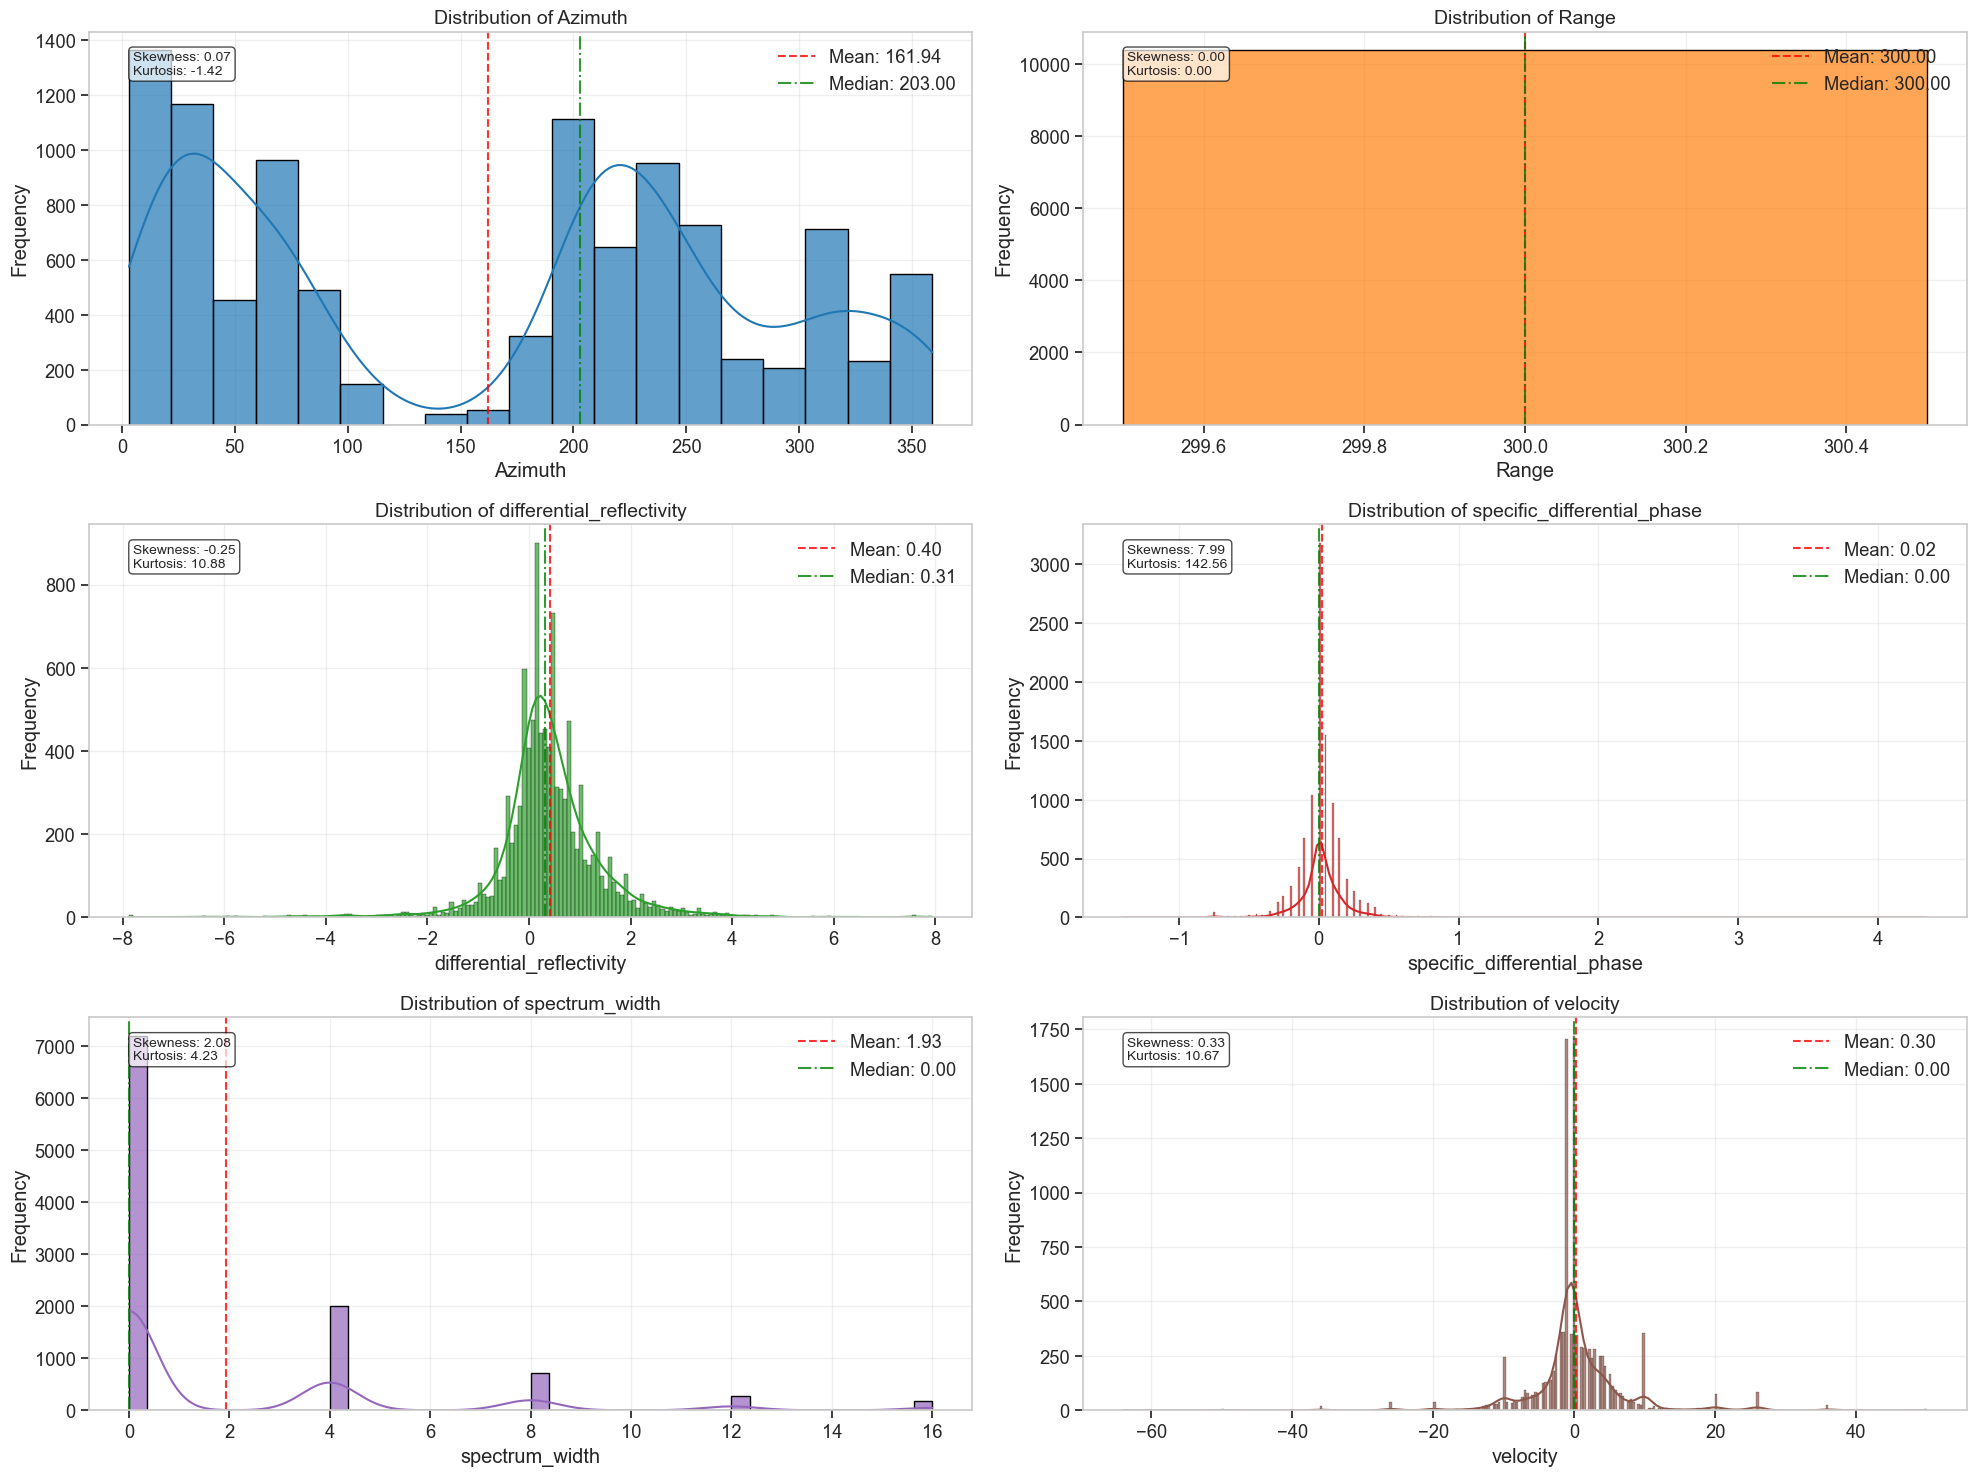

In [14]:
plt.figure(figsize=(20, 15))

# Helper function to create more informative distribution plots
def plot_parameter_distribution(data, param, position, color):
    ax = plt.subplot(3, 2, position)
    
    # Create a more detailed histogram with KDE
    sns.histplot(data[param], kde=True, color=color, alpha=0.7)
    
    # Add vertical lines for statistics
    mean = data[param].mean()
    median = data[param].median()
    plt.axvline(mean, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='green', linestyle='-.', alpha=0.8, label=f'Median: {median:.2f}')
    
    # Add skewness and kurtosis information
    skewness = data[param].skew()
    kurtosis = data[param].kurtosis()
    ax.text(0.05, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.title(f'Distribution of {param}', fontsize=14)
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
# Plot distributions of each parameter
columns = ['Azimuth', 'Range', 'differential_reflectivity',
       'specific_differential_phase', 'spectrum_width', 'velocity']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, (col, color) in enumerate(zip(columns, colors)):
    plot_parameter_distribution(df_cleaned, col, i+1, color)

plt.tight_layout()
plt.show()

Let's also create boxplots to further visualize the distributions and any remaining outliers.


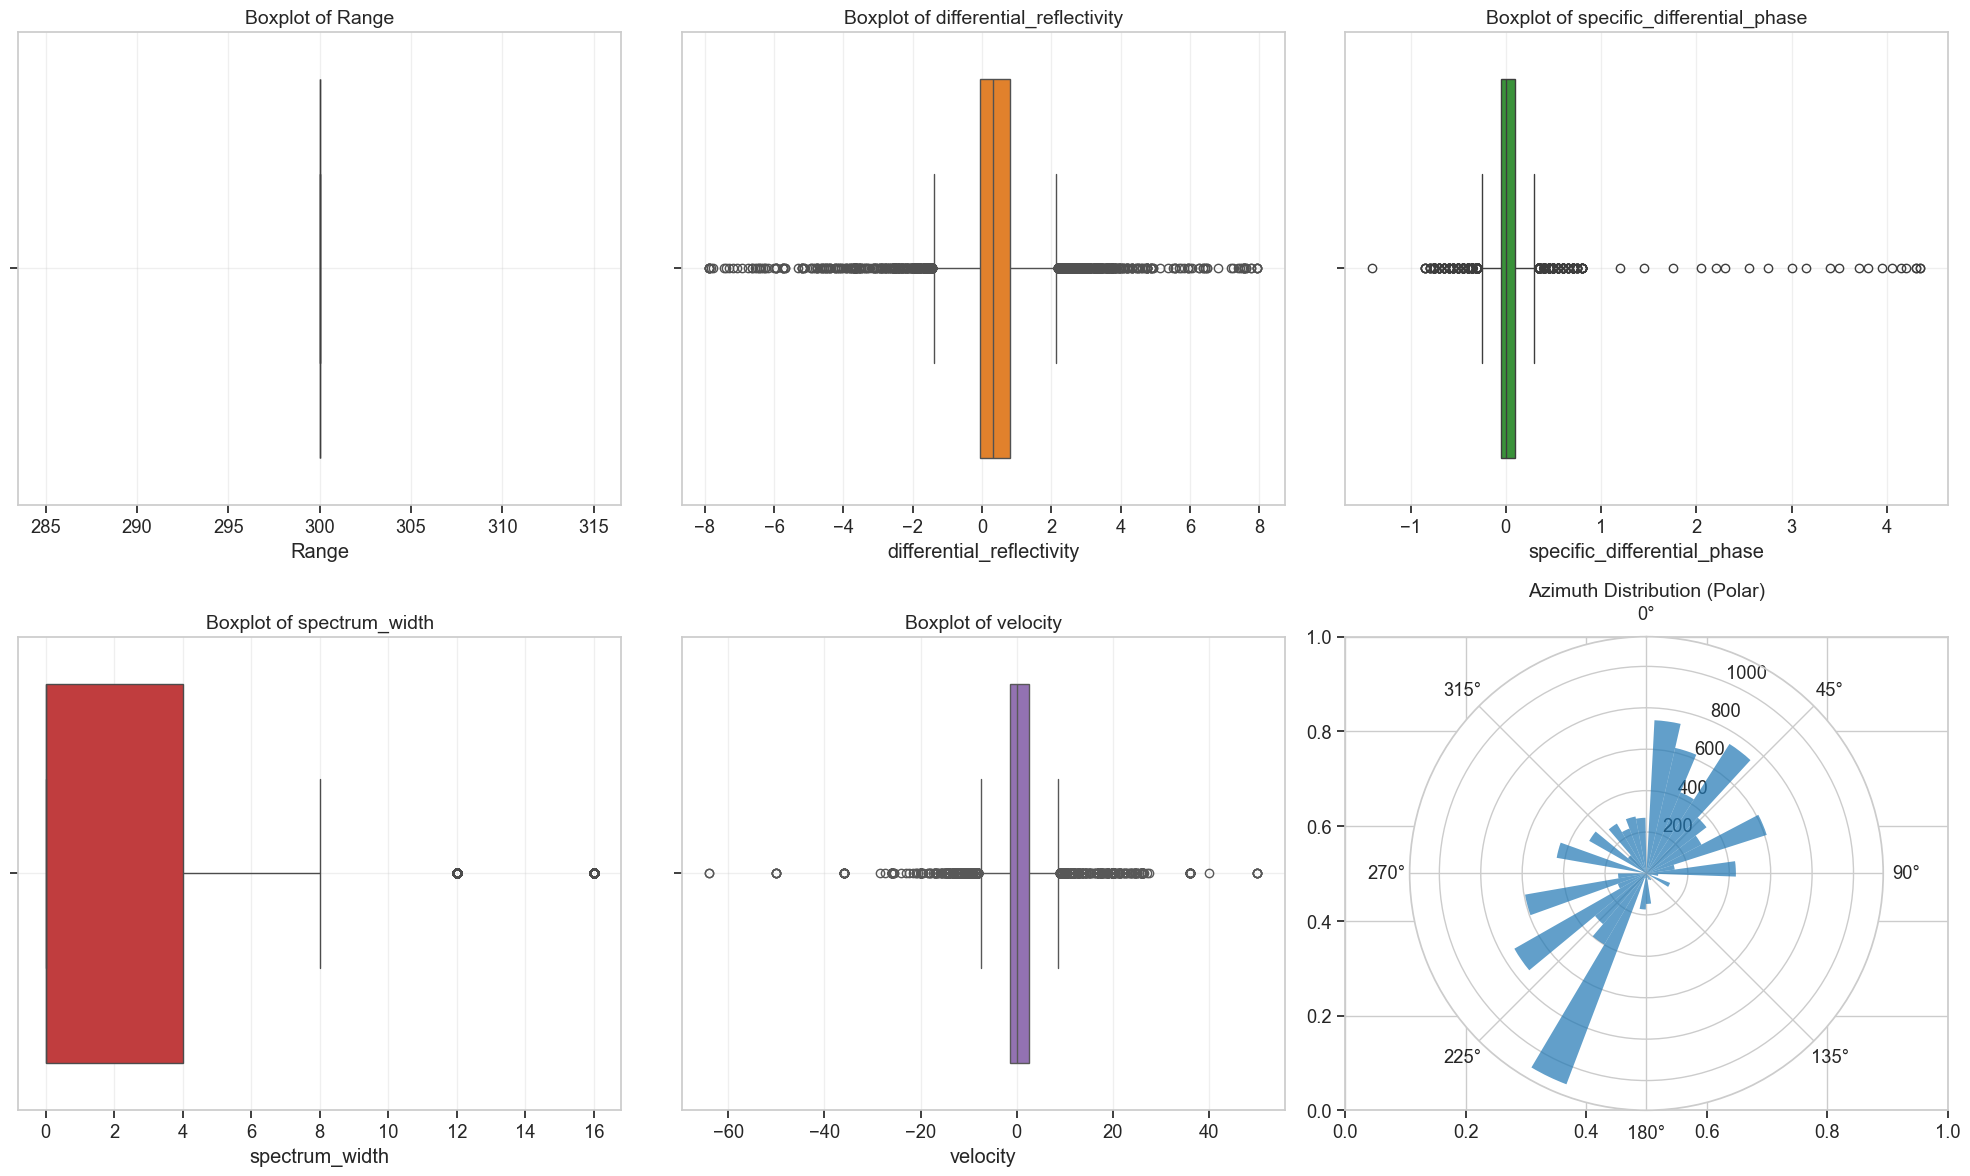

In [15]:
# Create boxplots
plt.figure(figsize=(20, 12))

# Standard boxplots for non-circular data
for i, col in enumerate([c for c in columns if c != 'Azimuth']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df_cleaned[col], color=colors[i])
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.xlabel(col)
    plt.grid(True, alpha=0.3)
    

# Special handling for Azimuth (circular data)
plt.subplot(2, 3, 6)
# For circular data like Azimuth, use a polar histogram
ax = plt.subplot(2, 3, 6, projection='polar')
azimuth_rad = np.deg2rad(df_cleaned['Azimuth'])
ax.hist(azimuth_rad, bins=36, color=colors[0], alpha=0.7)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(range(0, 360, 45))
ax.set_title('Azimuth Distribution (Polar)', fontsize=14)

plt.tight_layout()
plt.show()

### Correlation Analysis 

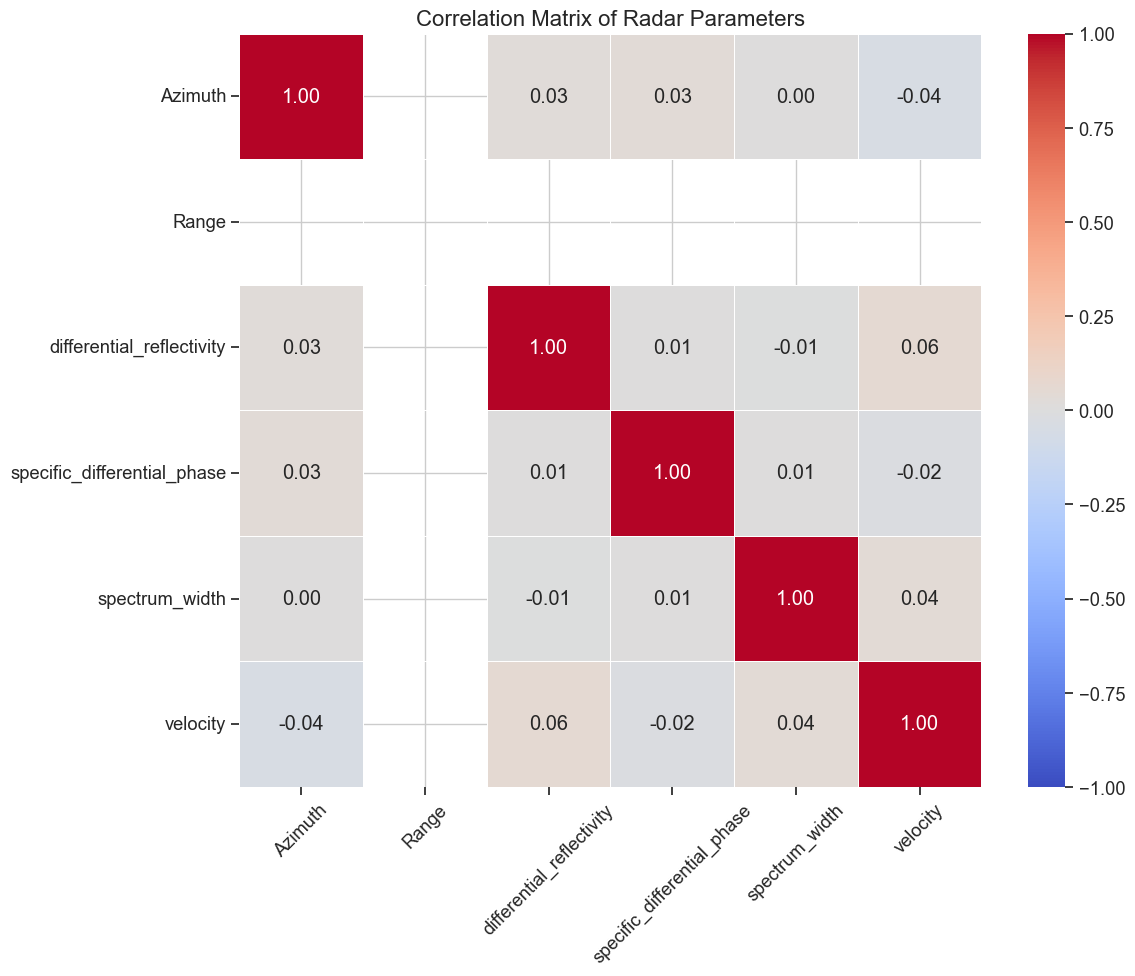

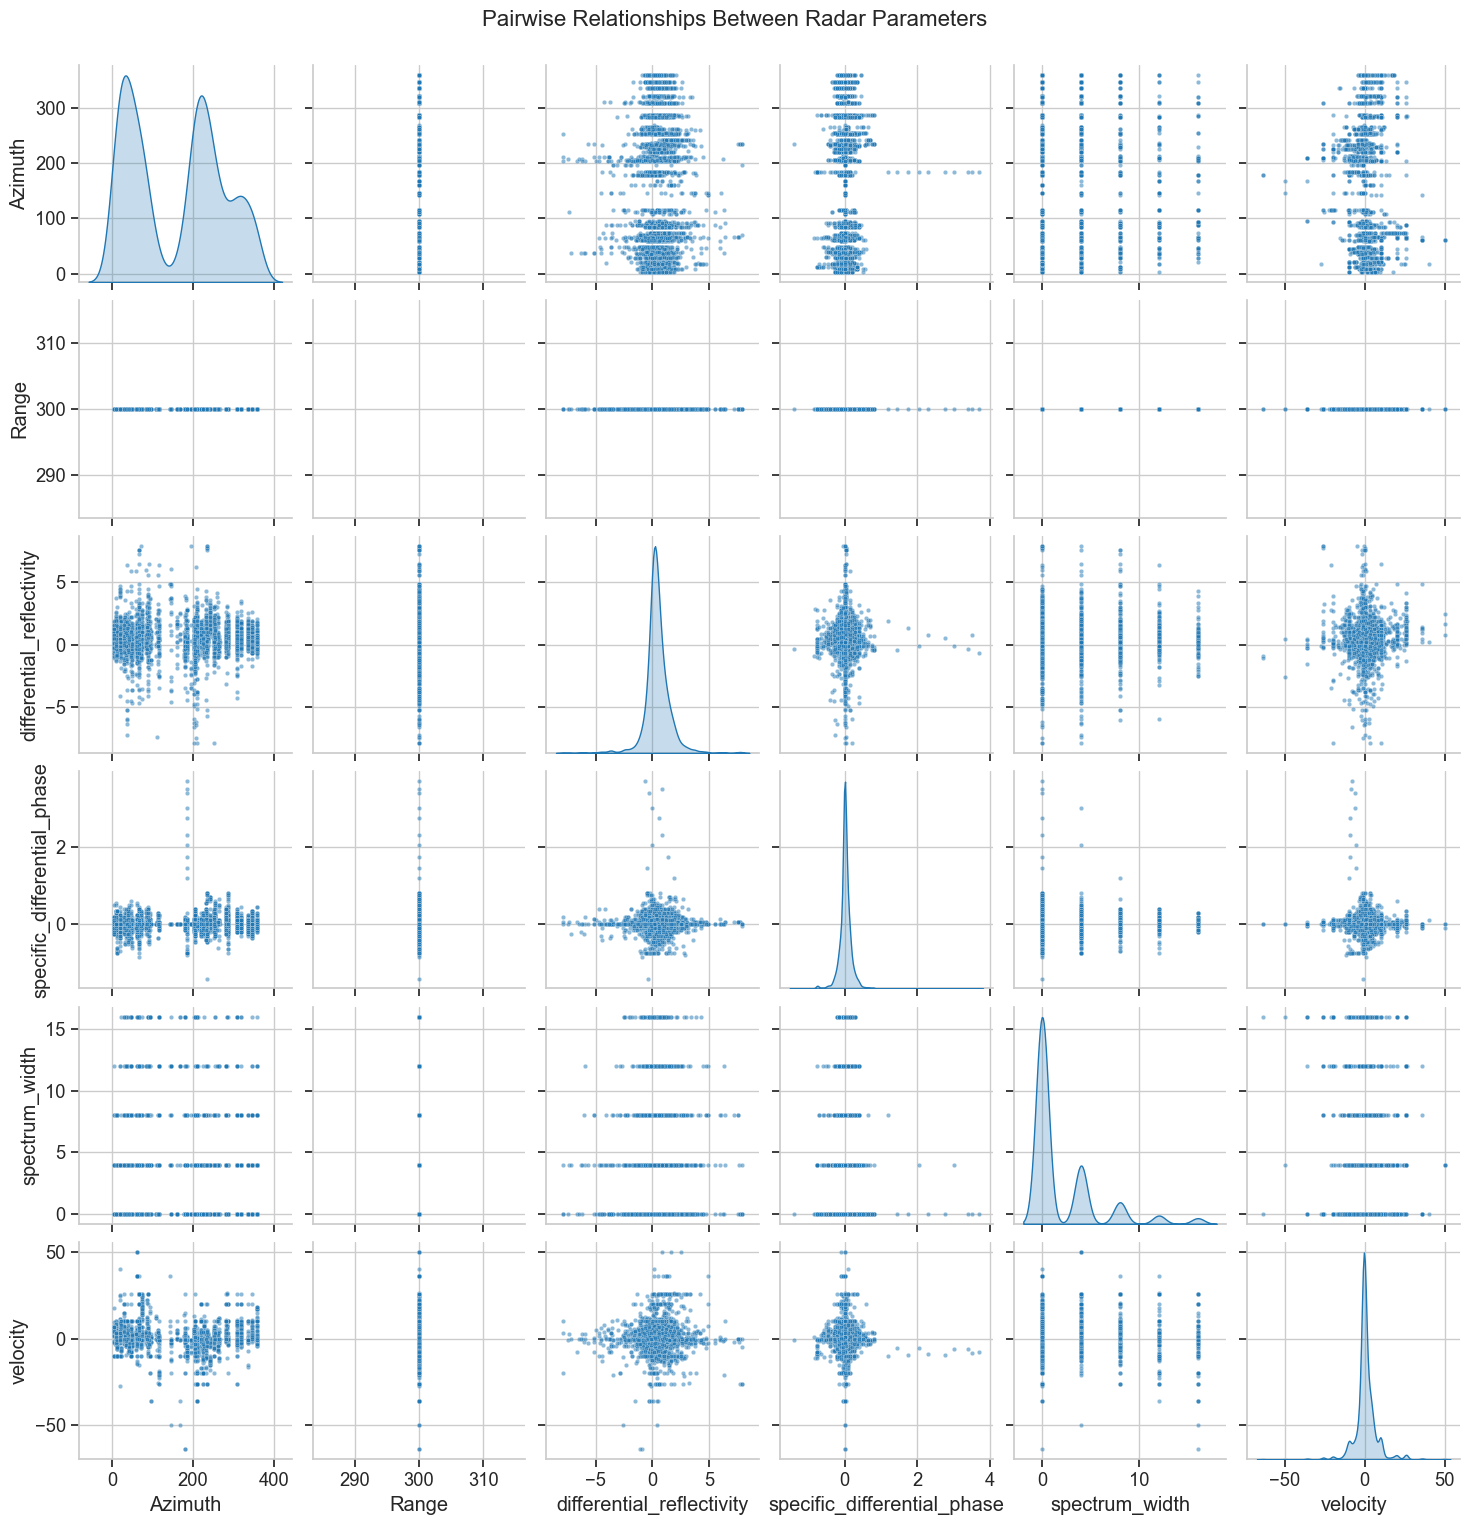

In [16]:
# Calculate correlation matrix
correlation_matrix = df_cleaned.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Radar Parameters', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Create scatterplot matrix to visualize relationships
# Using a subset of data points for clearer visualization
sample_size = min(5000, len(df_cleaned))
sampled_data = df_cleaned.sample(sample_size)

# Create pairplot
sns.pairplot(sampled_data, diag_kind='kde', plot_kws={'alpha': 0.5, 's': 10})
plt.suptitle('Pairwise Relationships Between Radar Parameters', fontsize=16, y=1.02)
plt.show()

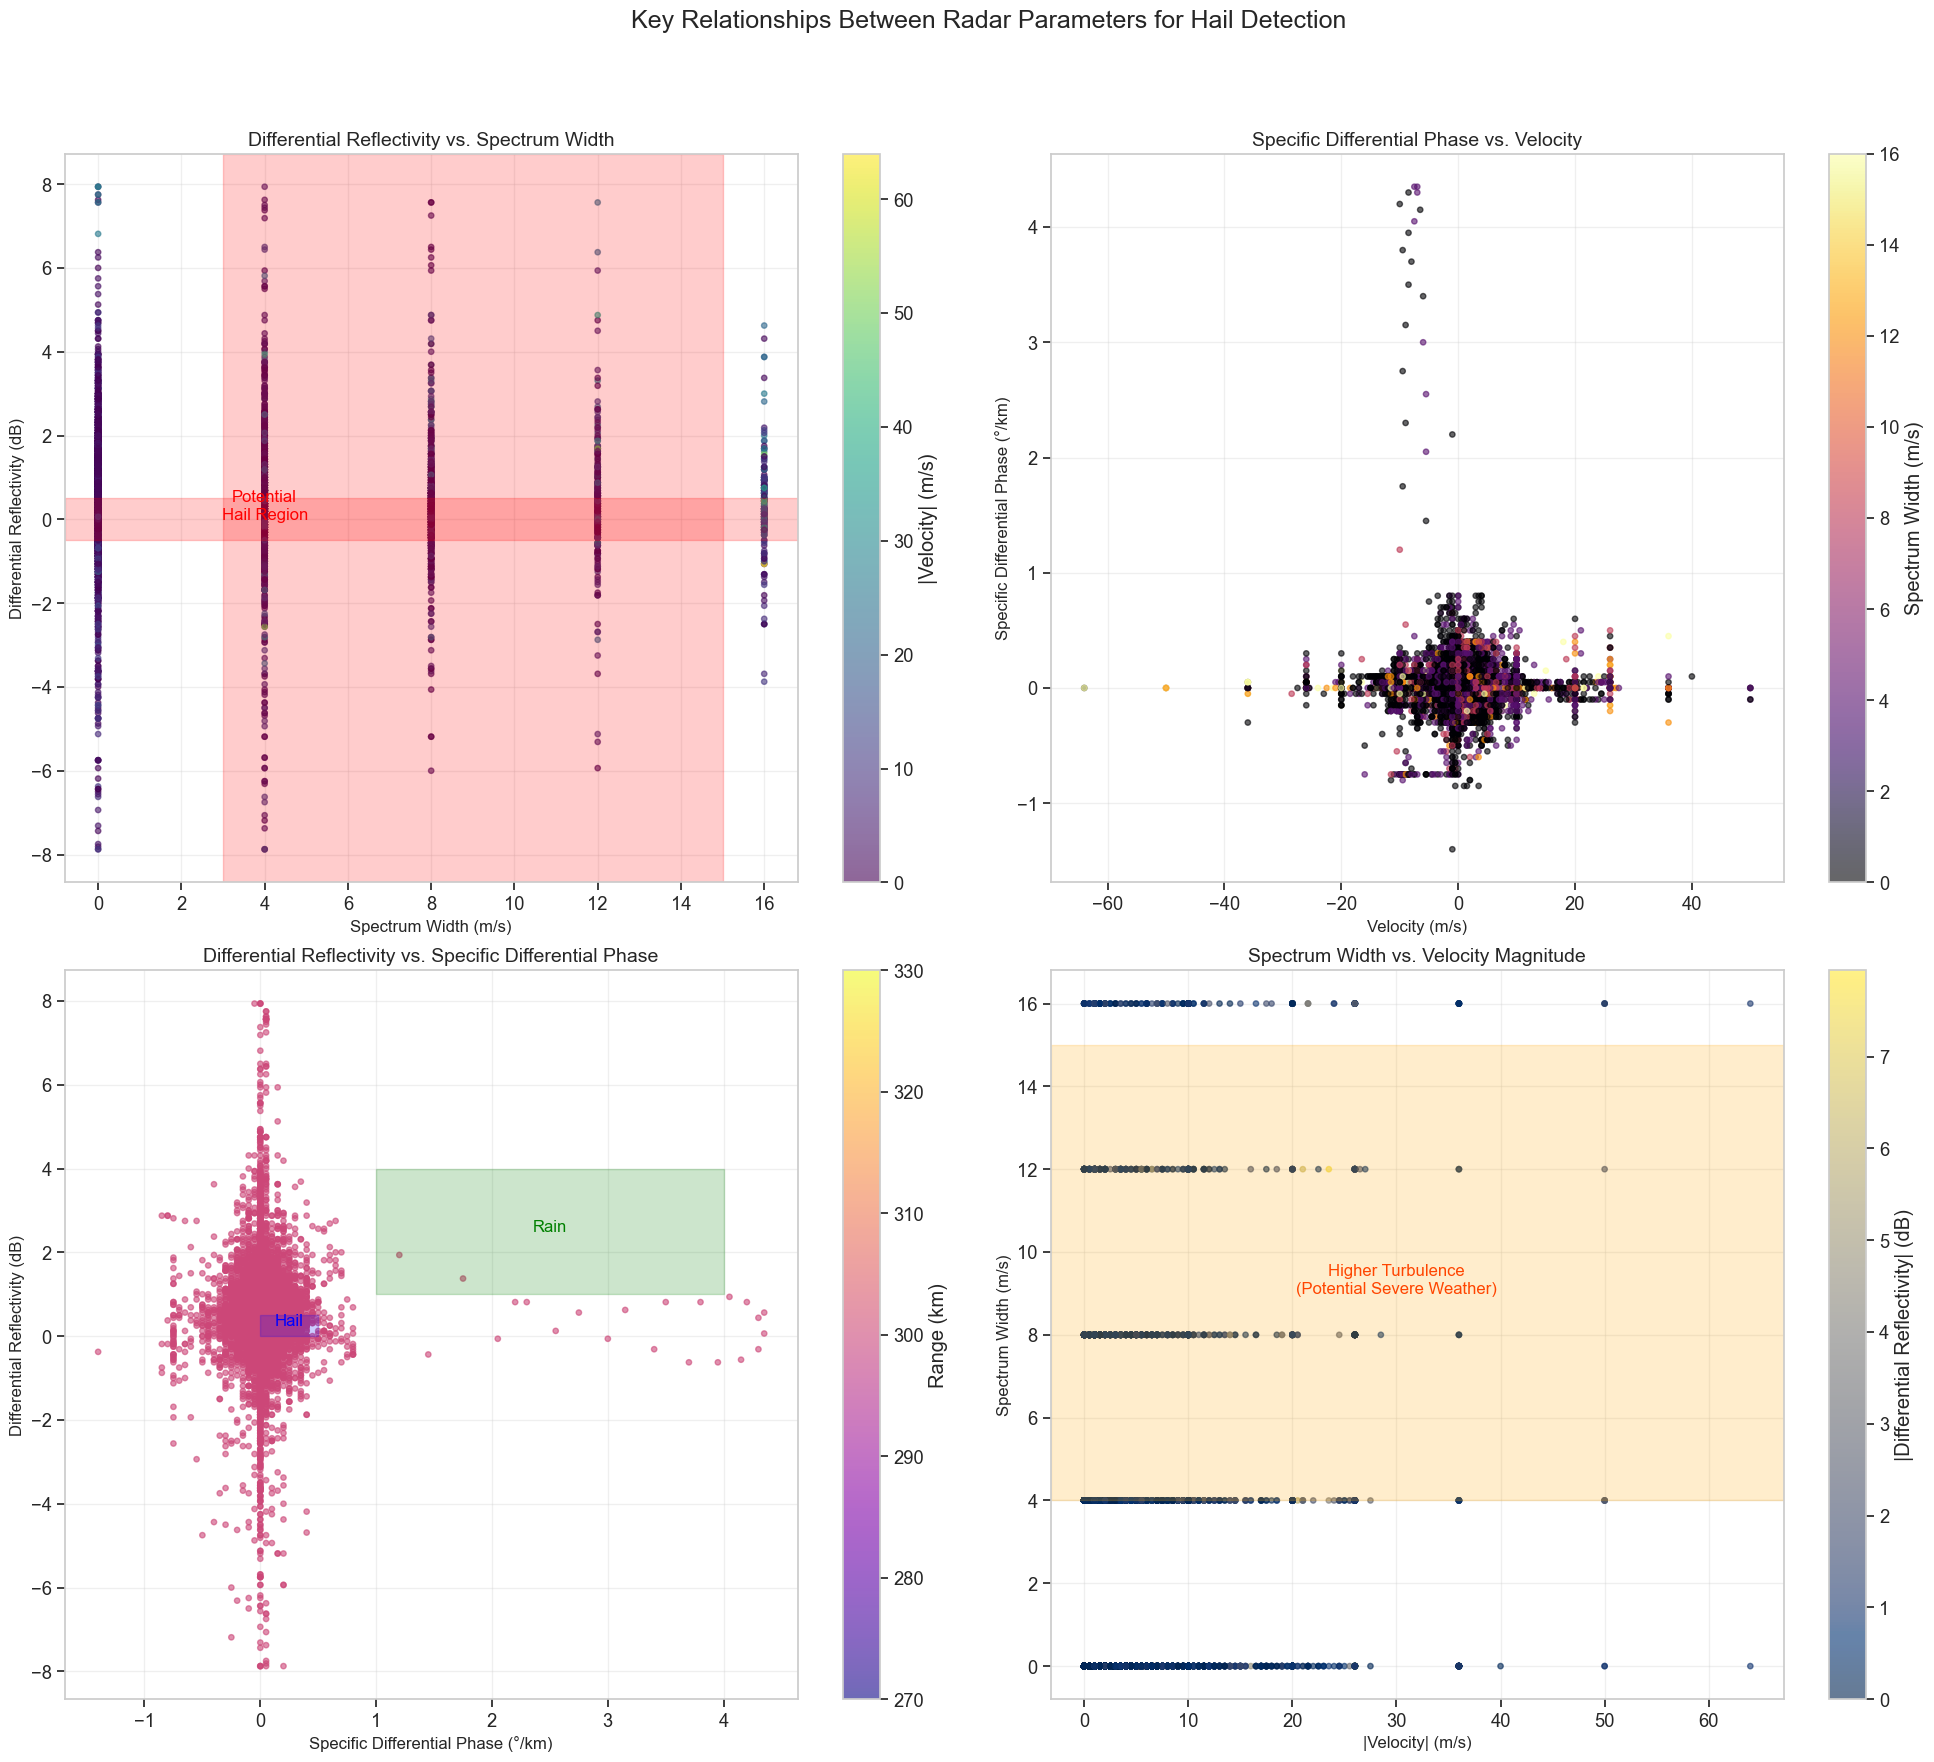

In [22]:
# Create scatter plots for specific parameter relationships that are important for hail detection
plt.figure(figsize=(20, 18))

# 1. Differential Reflectivity vs. Spectrum Width (important for hail detection)
ax1 = plt.subplot(2, 2, 1)
sc1 = plt.scatter(df_cleaned['spectrum_width'], df_cleaned['differential_reflectivity'], 
                c=df_cleaned['velocity'].abs(), cmap='viridis', alpha=0.6, s=15)
plt.colorbar(sc1, label='|Velocity| (m/s)')
plt.xlabel('Spectrum Width (m/s)', fontsize=12)
plt.ylabel('Differential Reflectivity (dB)', fontsize=12)
plt.title('Differential Reflectivity vs. Spectrum Width', fontsize=14)
plt.grid(True, alpha=0.3)

# Add annotations for potential hail signatures
ax1.axhspan(-0.5, 0.5, color='red', alpha=0.2)
ax1.axvspan(3, 15, color='red', alpha=0.2)
ax1.text(4, 0, 'Potential\nHail Region', color='red', fontsize=12, ha='center')

# 2. Specific Differential Phase vs. Velocity
ax2 = plt.subplot(2, 2, 2)
sc2 = plt.scatter(df_cleaned['velocity'], df_cleaned['specific_differential_phase'], 
                c=df_cleaned['spectrum_width'], cmap='inferno', alpha=0.6, s=15)
plt.colorbar(sc2, label='Spectrum Width (m/s)')
plt.xlabel('Velocity (m/s)', fontsize=12)
plt.ylabel('Specific Differential Phase (°/km)', fontsize=12)
plt.title('Specific Differential Phase vs. Velocity', fontsize=14)
plt.grid(True, alpha=0.3)

# 3. Differential Reflectivity vs. Specific Differential Phase
ax3 = plt.subplot(2, 2, 3)
sc3 = plt.scatter(df_cleaned['specific_differential_phase'], df_cleaned['differential_reflectivity'], 
                c=df_cleaned['Range'], cmap='plasma', alpha=0.6, s=15)
plt.colorbar(sc3, label='Range (km)')
plt.xlabel('Specific Differential Phase (°/km)', fontsize=12)
plt.ylabel('Differential Reflectivity (dB)', fontsize=12)
plt.title('Differential Reflectivity vs. Specific Differential Phase', fontsize=14)
plt.grid(True, alpha=0.3)


# Add annotations for typical precipitation types
ax3.add_patch(plt.Rectangle((0, 0), 0.5, 0.5, fill=True, color='blue', alpha=0.2))
ax3.text(0.25, 0.25, 'Hail', color='blue', fontsize=12, ha='center')

ax3.add_patch(plt.Rectangle((1, 1), 3, 3, fill=True, color='green', alpha=0.2))
ax3.text(2.5, 2.5, 'Rain', color='green', fontsize=12, ha='center')

# 4. Spectrum Width vs. Velocity magnitude
ax4 = plt.subplot(2, 2, 4)
sc4 = plt.scatter(df_cleaned['velocity'].abs(), df_cleaned['spectrum_width'], 
                c=df_cleaned['differential_reflectivity'].abs(), cmap='cividis', alpha=0.6, s=15)
plt.colorbar(sc4, label='|Differential Reflectivity| (dB)')
plt.xlabel('|Velocity| (m/s)', fontsize=12)
plt.ylabel('Spectrum Width (m/s)', fontsize=12)
plt.title('Spectrum Width vs. Velocity Magnitude', fontsize=14)
plt.grid(True, alpha=0.3)

# Highlight potential turbulent regions
ax4.axhspan(4, 15, color='orange', alpha=0.2)
ax4.text(30, 9, 'Higher Turbulence\n(Potential Severe Weather)', color='orangered', fontsize=12, ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Key Relationships Between Radar Parameters for Hail Detection', fontsize=18)
plt.show()


Let's also create a 3D visualization to better understand the multi-parameter relationships.


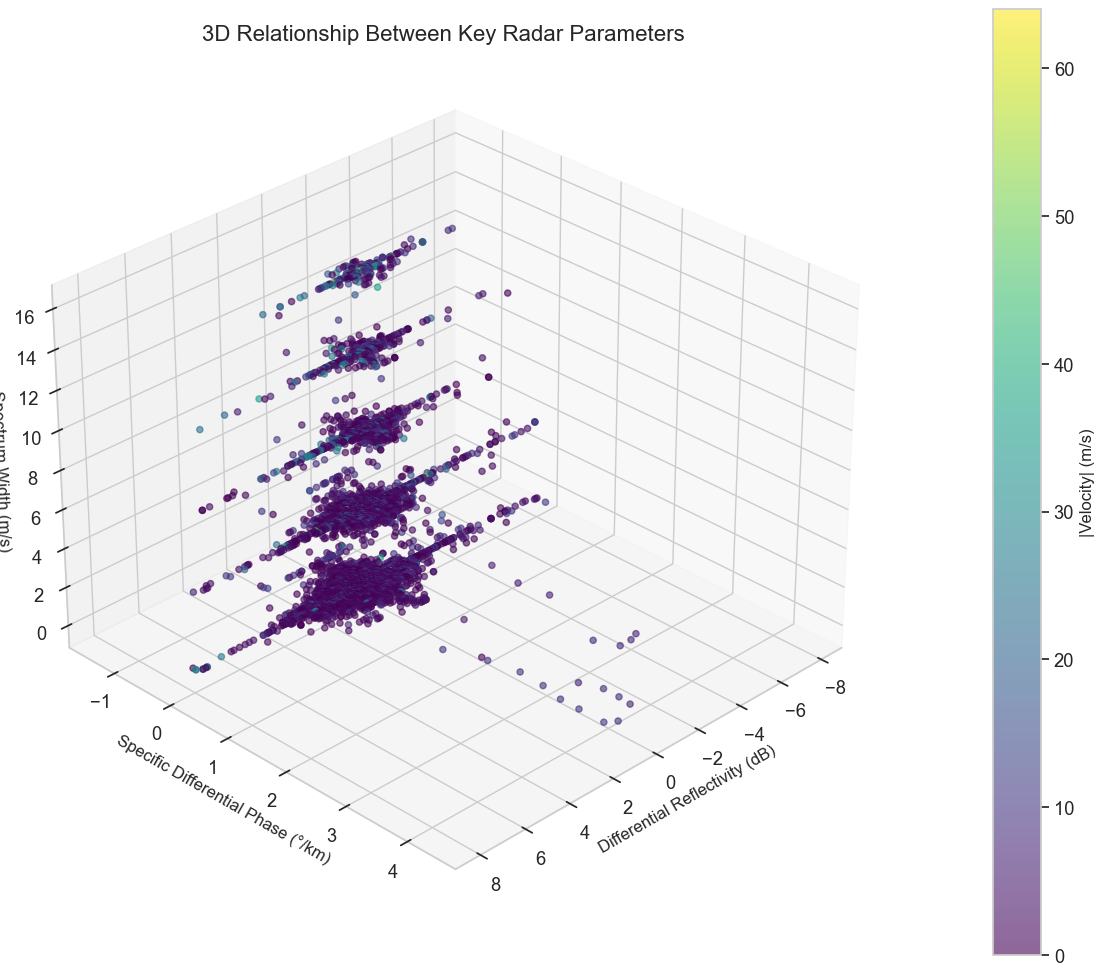

In [24]:
# Create a 3D scatter plot for three key parameters
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Use absolute values for Velocity for clearer visualization
sc = ax.scatter(df_cleaned['differential_reflectivity'], 
               df_cleaned['specific_differential_phase'],
               df_cleaned['spectrum_width'],
               c=df_cleaned['velocity'].abs(),
               cmap='viridis',
               s=20,
               alpha=0.6)

ax.set_xlabel('Differential Reflectivity (dB)', fontsize=12)
ax.set_ylabel('Specific Differential Phase (°/km)', fontsize=12)
ax.set_zlabel('Spectrum Width (m/s)', fontsize=12)
ax.set_title('3D Relationship Between Key Radar Parameters', fontsize=16)

# Add a color bar
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('|Velocity| (m/s)', fontsize=12)

# Rotate the plot for better visualization
ax.view_init(30, 45)
plt.tight_layout()
plt.show()


Now, let's create heatmaps to visualize the spatial distribution of each parameter in Cartesian coordinates.

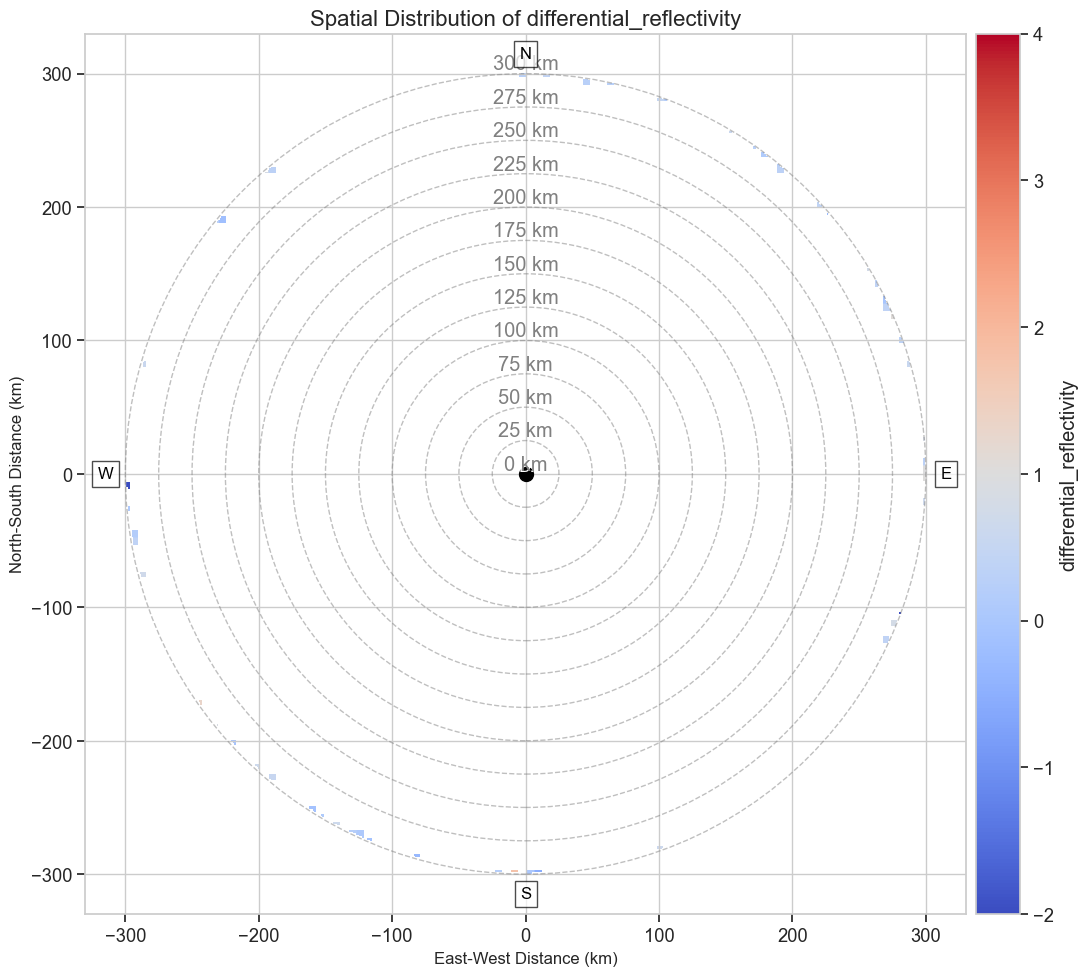

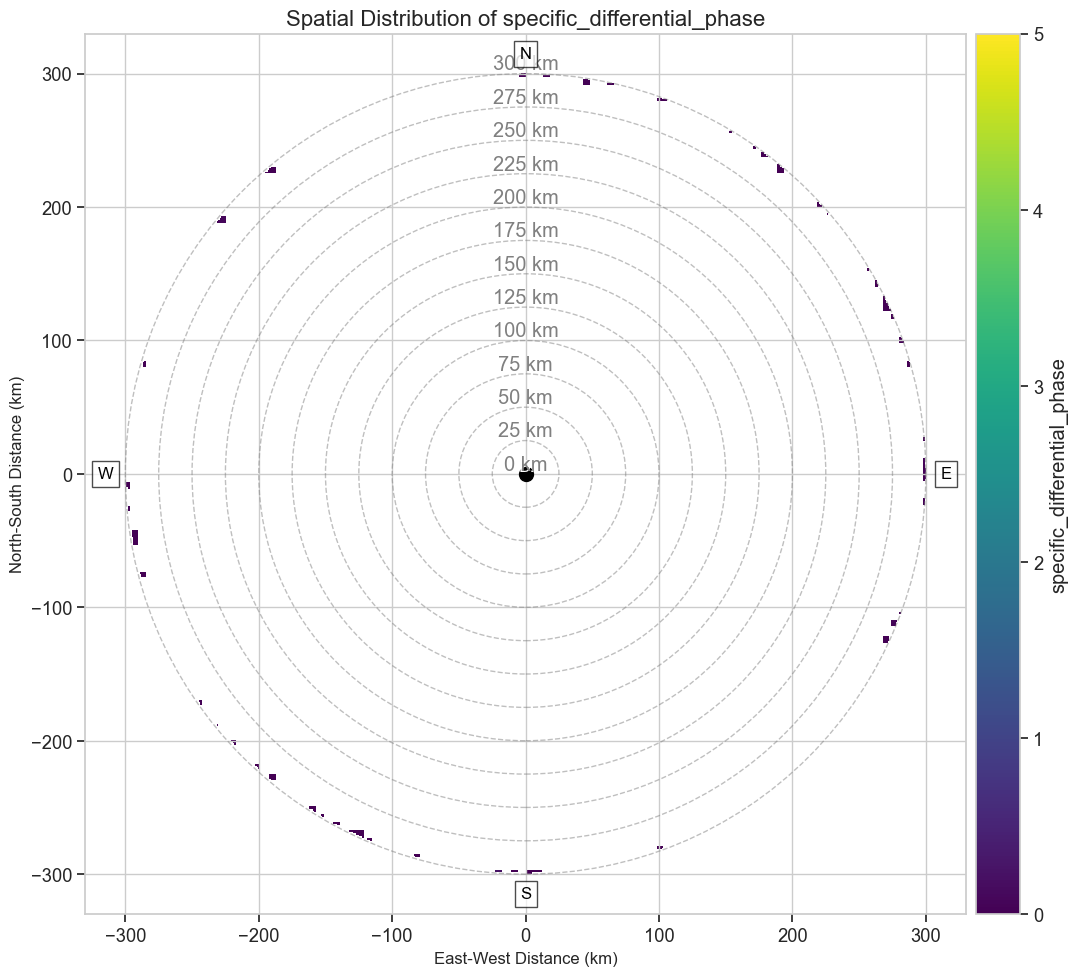

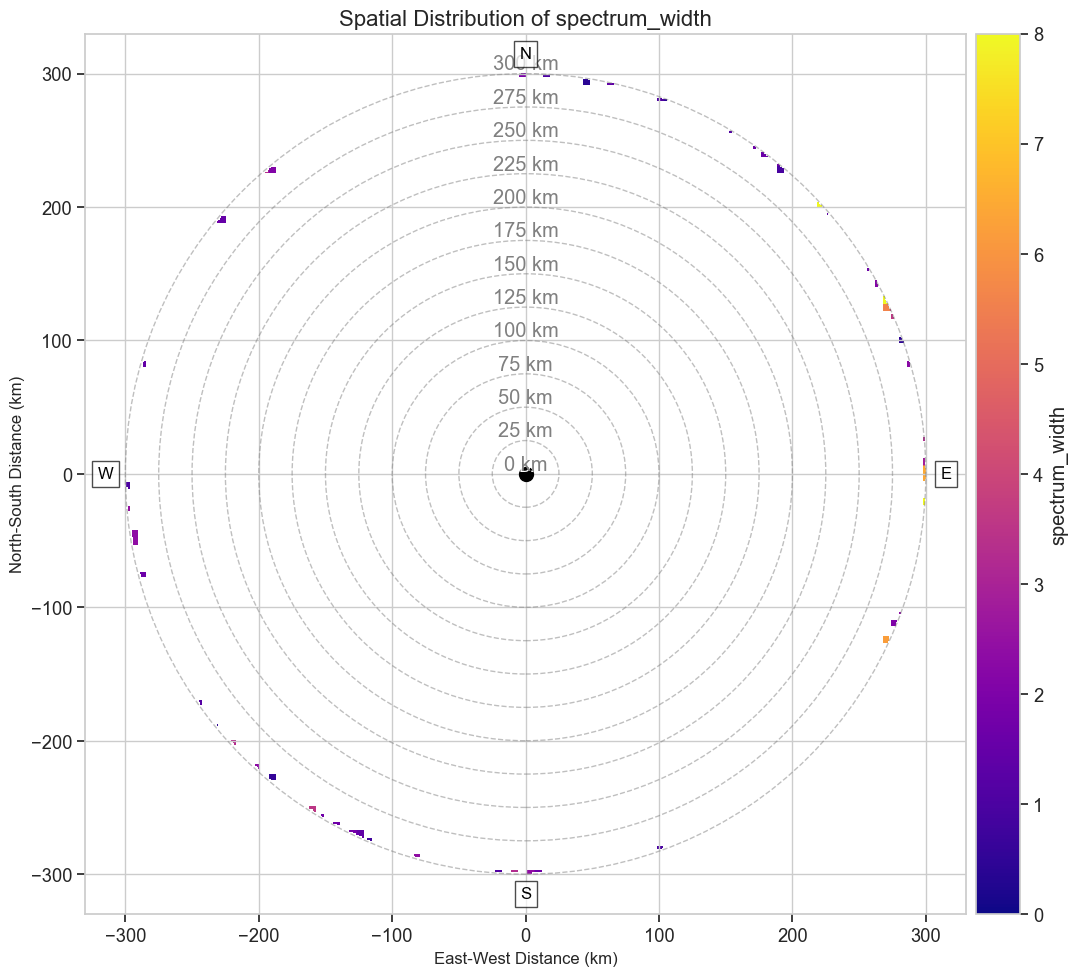

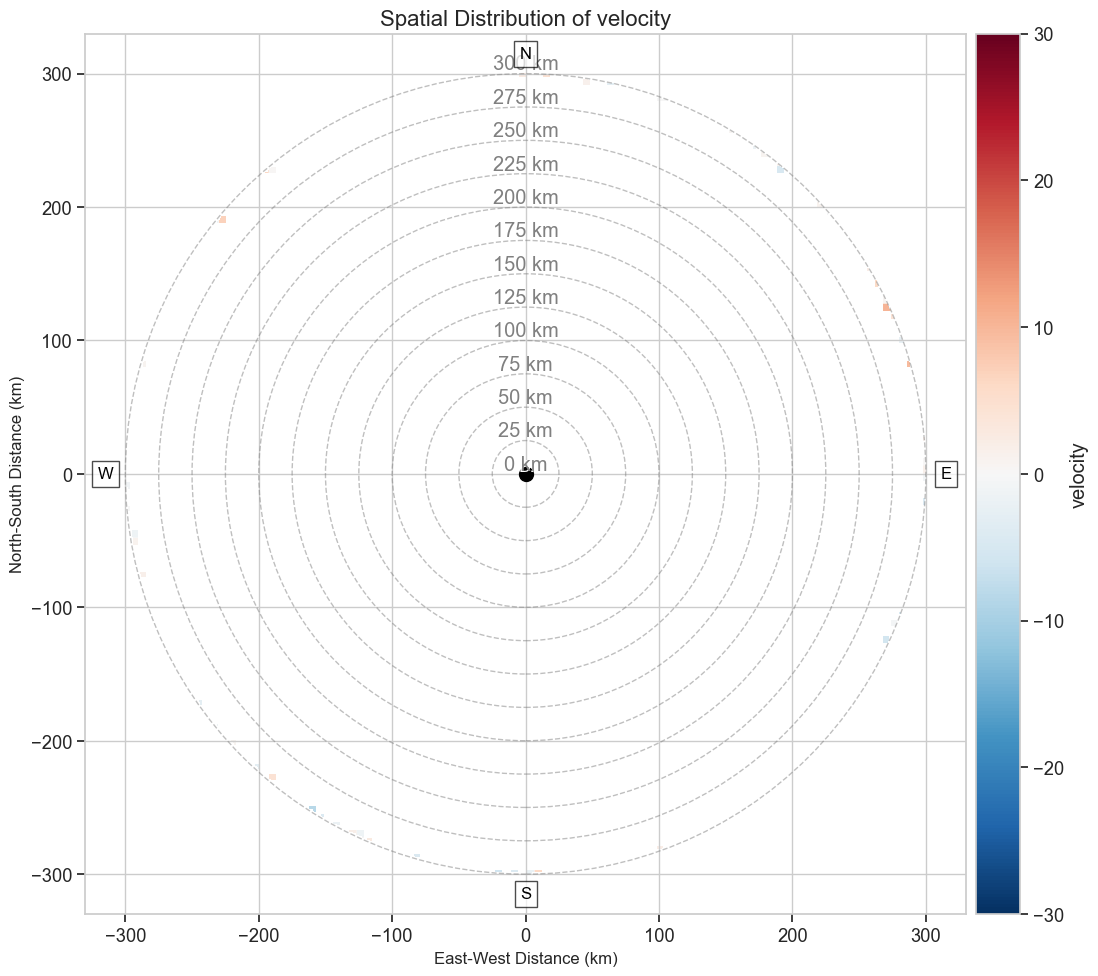

In [28]:
def polar_to_cartesian(azimuth_deg, range_km):
    azimuth_rad = np.deg2rad(azimuth_deg)
    x = range_km * np.sin(azimuth_rad)
    y = range_km * np.cos(azimuth_rad)
    return x, y

# Calculate Cartesian coordinates
df_cleaned['X'] = polar_to_cartesian(df_cleaned['Azimuth'], df_cleaned['Range'])[0]
df_cleaned['Y'] = polar_to_cartesian(df_cleaned['Azimuth'], df_cleaned['Range'])[1]

# Create a function to generate 2D heatmaps for each parameter
def create_parameter_heatmap(df, param, title, cmap, vmin=None, vmax=None):
    # Create a grid for interpolation
    x_min, x_max = df['X'].min(), df['X'].max()
    y_min, y_max = df['Y'].min(), df['Y'].max()
    grid_size = 500
    
    # Create a meshgrid
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Create a mask for points outside the maximum range
    max_range = df['Range'].max()
    mask = X**2 + Y**2 > max_range**2
    
    # Initialize the grid with NaN values
    grid_values = np.full_like(X, np.nan, dtype=float)
    
    # Use a simple binning approach for visualization
    # This is a simplified approach - for production code, consider proper interpolation methods
    bin_size = (x_max - x_min) / 100  # Adjust bin size based on your data density
    
    for i, x_center in enumerate(np.linspace(x_min, x_max, 100)):
        for j, y_center in enumerate(np.linspace(y_min, y_max, 100)):
            # Select points in this bin
            bin_points = df[(df['X'] >= x_center - bin_size/2) & 
                           (df['X'] < x_center + bin_size/2) &
                           (df['Y'] >= y_center - bin_size/2) & 
                           (df['Y'] < y_center + bin_size/2)]
            
            
            if len(bin_points) > 0:
                # Assign the mean value to grid cells in this bin
                x_indices = np.logical_and(X >= x_center - bin_size/2, X < x_center + bin_size/2)
                y_indices = np.logical_and(Y >= y_center - bin_size/2, Y < y_center + bin_size/2)
                grid_points = np.logical_and(x_indices, y_indices)
                
                grid_values[grid_points] = bin_points[param].mean()
                
                
 # Apply the mask
    grid_values[mask] = np.nan
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the heatmap
    im = ax.imshow(grid_values, cmap=cmap, origin='lower', 
                  extent=[x_min, x_max, y_min, y_max],
                  vmin=vmin, vmax=vmax)
    
     
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(param)
    
    # Add radar location
    ax.plot(0, 0, 'ko', markersize=10)
    ax.text(0, 0, 'RADAR', fontsize=12, ha='center', va='bottom', color='white')
    
    # Add range rings
    for r in range(0, int(max_range) + 1, 25):
        circle = plt.Circle((0, 0), r, fill=False, color='gray', linestyle='--', alpha=0.5)
        ax.add_patch(circle)
        ax.text(0, r, f'{r} km', color='gray', ha='center', va='bottom')
        
    # Add cardinal directions
    for angle, direction in zip([0, 90, 180, 270], ['N', 'E', 'S', 'W']):
        angle_rad = np.deg2rad(angle)
        r = max_range * 1.05
        x = r * np.sin(angle_rad)
        y = r * np.cos(angle_rad)
        ax.text(x, y, direction, fontsize=12, ha='center', va='center', color='black',
               bbox=dict(facecolor='white', alpha=0.7))
    
    # Set equal aspect and title
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('East-West Distance (km)', fontsize=12)
    ax.set_ylabel('North-South Distance (km)', fontsize=12)
    
    return fig, ax


# Generate heatmaps for each parameter
parameters = ['differential_reflectivity', 'specific_differential_phase', 
              'spectrum_width', 'velocity']
cmaps = ['coolwarm', 'viridis', 'plasma', 'RdBu_r']
vmins = [-2, 0, 0, -30]
vmaxs = [4, 5, 8, 30]

for param, cmap, vmin, vmax in zip(parameters, cmaps, vmins, vmaxs):
    title = f'Spatial Distribution of {param}'
    fig, ax = create_parameter_heatmap(df_cleaned, param, title, cmap, vmin, vmax)
    plt.tight_layout()
    plt.show()

Now, let's create a combined visualization that highlights potential hail regions based on multiple parameters.